In [0]:
import gym
import copy
import torch
from torch.autograd import Variable
import torch_xla
import torch_xla.core.xla_model as xm
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import time

In [0]:
# env = gym.envs.make("CartPole-v1")

In [0]:
env = gym.envs.make("Taxi-v3")

In [0]:
dev = xm.xla_device()

In [0]:
# def get_screen():
#     ''' Extract one step of the simulation.'''
#     screen = env.render(mode='rgb_array').transpose((2, 0, 1))
#     screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
#     return torch.from_numpy(screen)

# # Speify the number of simulation steps
# num_steps = 2

# # Show several steps
# for i in range(num_steps):
#     clear_output(wait=True)
#     env.reset()
#     plt.figure()
#     plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
#                interpolation='none')
#     plt.title('CartPole-v0 Environment')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [0]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [0]:
def plot_performance(title,performance_matrix,**kwargs):
    epochs=[]
    penalties=[]
    explore=[]
    exploit=[]
    for i,episode_performance in enumerate(performance_matrix):
        if 'interval' in kwargs:
            if i%kwargs['interval']==0:
                epochs.append(episode_performance[0])
                penalties.append(episode_performance[1])
        else:
            epochs.append(episode_performance[0])
            penalties.append(episode_performance[1])
    
    df=pd.DataFrame({'episodes': range(0,len(epochs)), 'epochs': epochs, 'penalties': penalties })
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    #plt.ylim(top=toplimit)
    if 'ylimit' in kwargs:
        plt.ylim(kwargs['ylimit'])
    if 'xlimit' in kwargs:
        plt.xlim(kwargs['xlimit'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    plt.plot( 'episodes', 'epochs', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
    plt.plot( 'episodes', 'penalties', data=df, marker='o', markerfacecolor='blue', markersize=1, color='olive', linewidth=4)
    plt.title(title)
    plt.legend()
    if 'save' in kwargs:
        plt.savefig(f"{kwargs['save']}")
    plt.show()


In [0]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, device=None, hidden_dim=64, lr=0.05, dropout=0.4):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
#                             torch.nn.Embedding(500, hidden_dim)
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(dropout),                        
#                             torch.nn.LeakyReLU(),
#                             torch.nn.Linear(hidden_dim, hidden_dim*2),
#                             torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, action_dim)
                    )
            if device is not None:
              self.device=device
              self.model = self.model.to(device)
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
            self.num_param_updates=0

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        self.model.train()
        state = torch.Tensor(state).to(self.device)
        y = Variable(torch.Tensor(y)).to(self.device)
        y_pred = self.model(state)
        loss = self.criterion(y_pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        xm.optimizer_step(self.optimizer, barrier=True)


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(state).to(self.device))
        
    

In [0]:
class OneHotGenerator():
    def __init__(self, num_labels):
        self.num_labels = num_labels
        self.one_hot_array = np.eye(num_labels)
    
    def get_one_hot(self, label):
        return self.one_hot_array[label]
    

In [0]:
# def learn(model_target, model_train, device, memory, size, n_update, gamma=0.9):
#         """ Add experience replay to the DQN network class. """
#         # Make sure the memory is big enough
#         if len(memory) >= size:
#             states = []
#             targets = []
#             # Sample a batch of experiences from the agent's memory
#             batch = random.sample(memory, size)
            
#             start_time = time.time()
#             # Extract information from the data
#             for state, action, next_state, reward, done in batch:
#                 states.append(state)
#                 # Predict q_values
#                 state = torch.Tensor(state).to(device)
#                 q_values = model_train.model(state).tolist()
#                 if done:
#                     q_values[action] = reward
#                 else:
#                     next_state = torch.Tensor(next_state).to(device)
#                     q_values_next = model_target.model(next_state).detach()
#                     q_values[action] = reward + gamma * torch.max(q_values_next).item()

#                 targets.append(q_values)

#             for_loop_duration = time.time() - start_time
#             print("For loop took %.2f secs" % for_loop_duration)

#             start_time = time.time()

#             model_train.update(states, targets)

#             model_update_time = time.time() - start_time
#             print("Model update took %.2f secs" % model_update_time)

#             model_train.num_param_updates += 1
#             if model_train.num_param_updates % n_update ==0:
#                 model_target.model.load_state_dict(model_train.model.state_dict())

In [0]:
class ExponentialSchedule():
    '''
    Exponential scheduling strategy.
    eps(t) = end_val + (start_val - end_val) * exp(-1.0 * t / decay_rate)
    Parameters:
        start_val: initial value (float)
        end_val: final value (float)
        decay_rate: rate of exponential decaying (int), usually steps or episodes
    '''
    def __init__(self, start_val = 1.0, end_val = 0.05, decay_rate = 200):
        self.start = start_val
        self.end = end_val
        self.decay = decay_rate

    def value(self, t):
        '''
        Calculates the current value at time t
        Parameters:
            t: current time/step/episode (int)
        '''
        return (self.end + (self.start - self.end) * np.exp(-1.0 * t / self.decay))


In [0]:
def learn(model_target, model_train, device, memory, size, n_update, gamma=0.9):
        """ Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        if len(memory) >= size:
            states = []
            targets = []
            # Sample a batch of experiences from the agent's memory
            batch = random.sample(memory, size)
            # print(batch)
            start_time = time.time()

            batch = np.array(batch)
            # print(batch)
            state_batch = torch.from_numpy(np.stack(batch[:, 0])).type(torch.FloatTensor).to(device)
            # print(state_batch.size())
            action_batch = torch.from_numpy(np.stack(batch[:, 1])).long().to(device)
            # print(action_batch.size())
            next_batch = torch.from_numpy(np.stack(batch[:, 2])).type(torch.FloatTensor).to(device)
            # print(next_batch.size())
            rew_batch = torch.from_numpy(np.stack(batch[:, 3])).to(device)
            # print(rew_batch.size())
            not_done_mask = torch.from_numpy(1 - np.stack(batch[:, 4])).to(device)
            # print(not_done_mask.size())

            q_values = model_train.model(state_batch).gather(1, action_batch.unsqueeze(1))

            next_max_q = model_target.model(next_batch).detach().max(1)[0]
            next_q_values = not_done_mask*next_max_q
            target_q_values = rew_batch + (gamma*next_q_values)
          

            for_loop_duration = time.time() - start_time
            # print("For loop took %.2f secs" % for_loop_duration)

            start_time = time.time()

            loss = model_train.criterion(q_values, target_q_values.unsqueeze(1))
            model_train.optimizer.zero_grad()
            loss.backward()
            xm.optimizer_step(model_train.optimizer, barrier=True)
            # model_train.update(states, targets)

            model_update_time = time.time() - start_time
            # print("Model update took %.2f secs" % model_update_time)

            model_train.num_param_updates += 1
            if model_train.num_param_updates % n_update ==0:
                model_target.model.load_state_dict(model_train.model.state_dict())

In [0]:
def q_learning(env, model_train, model_target, device, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=150, 
               title = 'DQL', double=False, 
               n_update=1000, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    one_hot_gen =  OneHotGenerator(env.observation_space.n)
    scheduler = ExponentialSchedule()
    epsilon = scheduler.value(0)
    q_learning_performance_matrix = []
    for episode in range(episodes):
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        state = one_hot_gen.get_one_hot(state)
#         state = list(env.env.decode(state))
        done = False
        total = 0
        steps = 0
        penalties = 0
        
        epsilon = scheduler.value(episode+1)

        while not done:
            # Implement greedy search policy to explore the state space
            steps +=1            

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model_target.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            next_state = one_hot_gen.get_one_hot(next_state)
#             next_state = list(env.env.decode(next_state))
            # Update total and memory
            # total += reward
            if reward==-10:
                penalties+=1
            total+=penalties
            memory.append((state, action, next_state, reward, done))
#             q_values = model.predict(state).tolist()
            if steps>100:
                learn(model_target, model_train, device, memory, replay_size, n_update, gamma)
            
            state = next_state
        
        # Update epsilon
        # epsilon = max(epsilon * eps_decay, 0.01)
        q_learning_performance_matrix.append([steps, penalties])
        final.append(total)
        plot_res(final, title)
    return final, q_learning_performance_matrix

In [0]:
# Number of states
n_state = env.observation_space.n
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 150
# Learning rate
lr = 0.0003

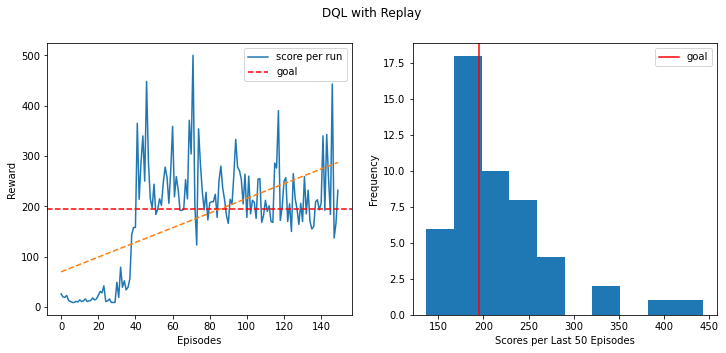

In [0]:
dqn_replay = DQL(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=0.99, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

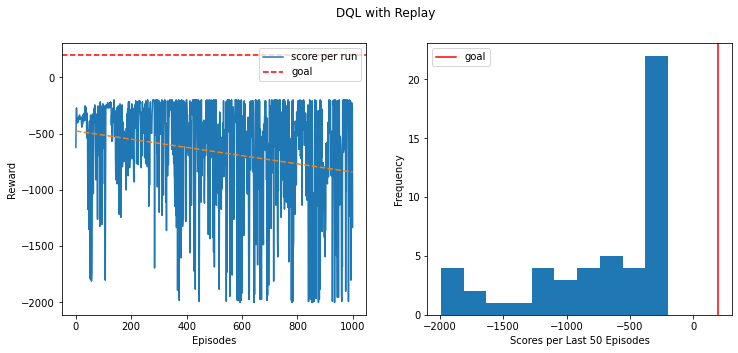

In [0]:
dqn_replay = DQL(4, 6, 150, lr)
replay = q_learning(env, dqn_replay, 
                    1000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

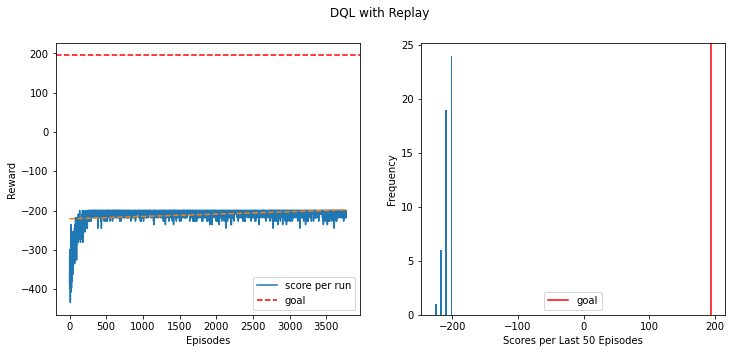

In [0]:
dqn_train = DQL(4, 6, n_hidden, lr)
dqn_target= DQL(4, 6, n_hidden, lr)

dqn_train.model.train()
dqn_target.model.eval()

replay = q_learning(env, dqn_train, dqn_target, 
                    5000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

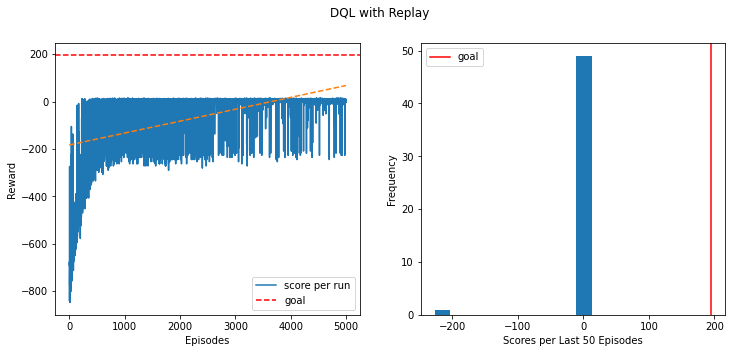

In [0]:
dqn_train = DQL(n_state, 6, dev, n_hidden, lr)
dqn_target= DQL(n_state, 6, dev, n_hidden, lr)

dqn_train.model.train()
dqn_target.model.eval()

replay = q_learning(env, dqn_train, dqn_target, dev,
                    5000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

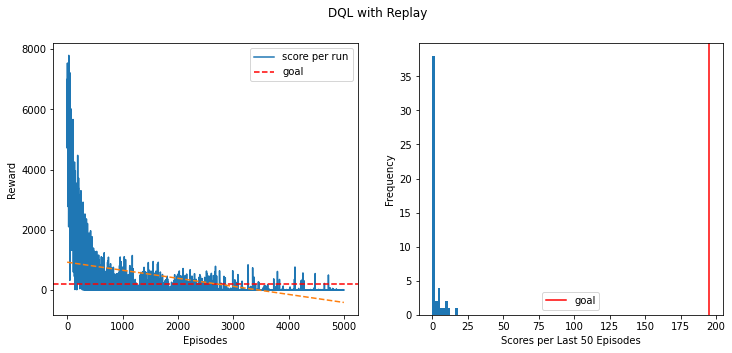

In [0]:
dqn_train = DQL(n_state, 6, dev, n_hidden, lr)
dqn_target= DQL(n_state, 6, dev, n_hidden, lr)

dqn_train.model.train()
dqn_target.model.eval()

final, q_learning_performance_matrix = q_learning(env, dqn_train, dqn_target, dev,
                    5000, gamma=.99, 
                    epsilon=0.3, replay=True, 
                    title='DQL with Replay')

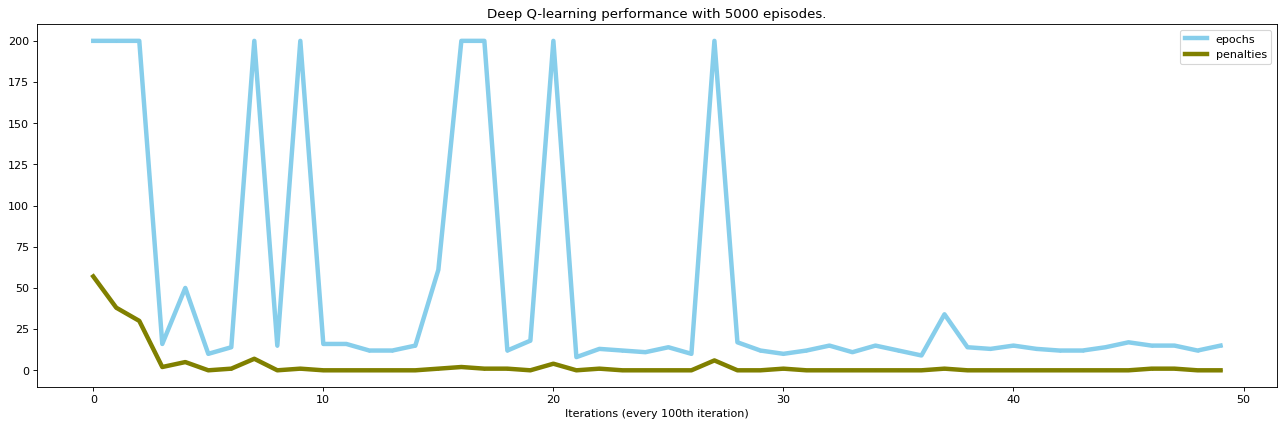

In [0]:
import pandas as pd
title1 = f"Deep Q-learning performance with 5000 episodes."
interval=100
plot_performance(title1,q_learning_performance_matrix,xlabel=f"Iterations (every {interval}th iteration)",interval=interval,save='random-search.png')

In [0]:
np.array(q_learning_performance_matrix)[:, 1]

array([57, 54, 64, ...,  1,  0,  1])